In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import shutil
import numpy as np
import glob   
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Input, Add,Dropout, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import  plot_model
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from IPython.display import SVG
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline


In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

In [4]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path('/kaggle/input/flowers-recognition/flowers') # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['daisy' 'dandelion' 'rose' 'sunflower' 'tulip']


Image shape: (281, 500, 3)


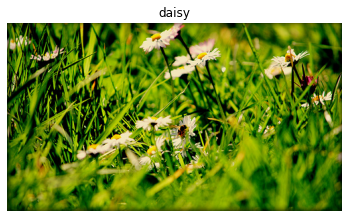

In [5]:
# View a random image from the training dataset
img = view_random_image(target_dir="/kaggle/input/flowers-recognition/flowers/",
                        target_class="daisy")

In [6]:
! pip install split-folders
import splitfolders

In [7]:
splitfolders.ratio("/kaggle/input/flowers-recognition/flowers/", output="../kaggle/working/Split",
    seed=1337, ratio=(.8, .1, 0.1), group_prefix=None, move=False) # default values

Copying files: 4317 files [00:17, 240.33 files/s]


In [8]:
data_dir = pathlib.Path('../kaggle/working/Split/') # turn our training path into a Python path
waalk = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(waalk)

['test' 'train' 'val']


In [9]:
 %config Completer.use_jedi = False

In [10]:
image_size = 224
batch_size = 64
training_dir = "../kaggle/working/Split/train"
val_dir = "../kaggle/working/Split/val"
test_dir = "../kaggle/working/Split/test"
train_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                    rotation_range=0.2, width_shift_range=0.2, zoom_range=0.2, horizontal_flip=True, height_shift_range=0.1)
valid_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                    rotation_range=0.2, width_shift_range=0.2, zoom_range=0.2, horizontal_flip=True, height_shift_range=0.1)
train_data = train_data_gen.flow_from_directory(training_dir, (image_size,image_size), batch_size=batch_size, class_mode='categorical', shuffle=True)
valid_data = valid_data_gen.flow_from_directory(val_dir, (image_size,image_size), batch_size=batch_size, class_mode='categorical', shuffle= True)

Found 3452 images belonging to 5 classes.
Found 430 images belonging to 5 classes.


In [11]:
image, label = train_data.next()

In [12]:
image[9]

array([[[-100.939   , -107.779   ,  -95.68    ],
        [-100.939   , -107.779   ,  -95.68    ],
        [-101.71363 , -110.10289 ,  -98.77852 ],
        ...,
        [ -31.32602 ,  -32.166016,  -28.658356],
        [ -34.555862,  -35.39586 ,  -30.988434],
        [ -37.47728 ,  -38.317276,  -33.218277]],

       [[-100.939   , -107.779   ,  -95.68    ],
        [-100.939   , -107.779   ,  -95.68    ],
        [-101.7154  , -110.10819 ,  -98.78558 ],
        ...,
        [ -31.331322,  -32.171318,  -28.667198],
        [ -34.562935,  -35.40293 ,  -30.991966],
        [ -37.482582,  -38.32258 ,  -33.22358 ]],

       [[-100.939   , -107.779   ,  -95.68    ],
        [-100.939   , -107.779   ,  -95.68    ],
        [-101.71717 , -110.113495,  -98.792656],
        ...,
        [ -31.336624,  -32.17662 ,  -28.676033],
        [ -34.570007,  -35.410004,  -30.995499],
        [ -37.487885,  -38.32788 ,  -33.22888 ]],

       ...,

       [[-101.53806 ,  -79.17994 ,  -80.08094 ],
        [-1

In [13]:
base_cnn_model = tf.keras.Sequential([
                                      Conv2D(10, 3, activation='relu', input_shape=(224,224,3)),
                                      Conv2D(10, 3, activation='relu'),
                                      MaxPooling2D((2,2)),
                                      Conv2D(10, 3, activation='relu'),
                                      Conv2D(10, 3, activation='relu'),
                                      MaxPooling2D((2,2)),
                                      Conv2D(10, 3, activation='relu'),
                                      Conv2D(10, 3, activation='relu'),
                                      MaxPooling2D((2,2)),
                                      Flatten(),
                                      Dense(5, activation='softmax')

])

2022-04-12 04:10:00.535356: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 04:10:00.618907: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 04:10:00.619685: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 04:10:00.621104: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [14]:
base_cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
base_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 10)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 51, 51, 10)        9

In [16]:
hist1 = base_cnn_model.fit(train_data,epochs=5, validation_data=valid_data, validation_steps=len(valid_data))

2022-04-12 04:10:04.207421: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-04-12 04:10:06.361083: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


54/54 [==============================] - 56s 900ms/step - loss: 2.6367 - accuracy: 0.2233 - val_loss: 1.5856 - val_accuracy: 0.2442
Epoch 2/5
54/54 [==============================] - 49s 902ms/step - loss: 1.5149 - accuracy: 0.2865 - val_loss: 1.4722 - val_accuracy: 0.3256
Epoch 3/5
54/54 [==============================] - 48s 881ms/step - loss: 1.4401 - accuracy: 0.3647 - val_loss: 1.4250 - val_accuracy: 0.3721
Epoch 4/5
54/54 [==============================] - 48s 891ms/step - loss: 1.4092 - accuracy: 0.3937 - val_loss: 1.4166 - val_accuracy: 0.4070
Epoch 5/5
54/54 [==============================] - 48s 886ms/step - loss: 1.3881 - accuracy: 0.4148 - val_loss: 1.3923 - val_accuracy: 0.4093


In [17]:
def get_model():
  base_transfer_model = ResNet50(weights='imagenet', include_top=False)
  for layer in base_transfer_model.layers:
    layer.trainable = False

  base_transfer_model_output = base_transfer_model.output
  x = GlobalAveragePooling2D()(base_transfer_model_output)
  x= Dense(512, activation='relu')(x)
  x = Dense(5, activation='softmax')(x)
  model_resnet = Model(inputs=base_transfer_model.input, outputs = x)
  return model_resnet

In [18]:
model_res = get_model()

94781440/94765736 [==============================] - 1s 0us/step


In [19]:
model_res.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [20]:
model_res.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [21]:
hist2= model_res.fit(train_data,epochs=5, steps_per_epoch = train_data.n//batch_size, validation_data=valid_data, validation_steps=valid_data.n//batch_size)

Epoch 1/5
53/53 [==============================] - 54s 968ms/step - loss: 0.7898 - accuracy: 0.7231 - val_loss: 0.4397 - val_accuracy: 0.8490
Epoch 2/5
53/53 [==============================] - 50s 950ms/step - loss: 0.4332 - accuracy: 0.8506 - val_loss: 0.4021 - val_accuracy: 0.8620
Epoch 3/5
53/53 [==============================] - 50s 943ms/step - loss: 0.3717 - accuracy: 0.8728 - val_loss: 0.3853 - val_accuracy: 0.8594
Epoch 4/5
53/53 [==============================] - 50s 933ms/step - loss: 0.3277 - accuracy: 0.8855 - val_loss: 0.3563 - val_accuracy: 0.8776
Epoch 5/5
53/53 [==============================] - 50s 938ms/step - loss: 0.3006 - accuracy: 0.8949 - val_loss: 0.3045 - val_accuracy: 0.9036


In [22]:
for layer in model_res.layers[:140]: layer.trainable = False
for layer in model_res.layers[140:]: layer.trainable = True
sgd = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model_res.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
hist3 = model_res.fit(train_data,epochs=14, steps_per_epoch = len(train_data),  validation_data=valid_data, validation_steps=len(valid_data))


Epoch 1/14
54/54 [==============================] - 56s 988ms/step - loss: 0.3894 - accuracy: 0.8757 - val_loss: 0.3068 - val_accuracy: 0.8837
Epoch 2/14
54/54 [==============================] - 51s 940ms/step - loss: 0.2464 - accuracy: 0.9229 - val_loss: 0.2545 - val_accuracy: 0.9140
Epoch 3/14
54/54 [==============================] - 51s 955ms/step - loss: 0.1912 - accuracy: 0.9415 - val_loss: 0.2513 - val_accuracy: 0.9186
Epoch 4/14
54/54 [==============================] - 50s 930ms/step - loss: 0.1564 - accuracy: 0.9508 - val_loss: 0.2296 - val_accuracy: 0.9116
Epoch 5/14
54/54 [==============================] - 52s 951ms/step - loss: 0.1285 - accuracy: 0.9626 - val_loss: 0.2199 - val_accuracy: 0.9326
Epoch 6/14
54/54 [==============================] - 51s 938ms/step - loss: 0.1039 - accuracy: 0.9710 - val_loss: 0.2480 - val_accuracy: 0.9233
Epoch 7/14
54/54 [==============================] - 51s 947ms/step - loss: 0.0922 - accuracy: 0.9733 - val_loss: 0.2485 - val_accuracy: 0.9209

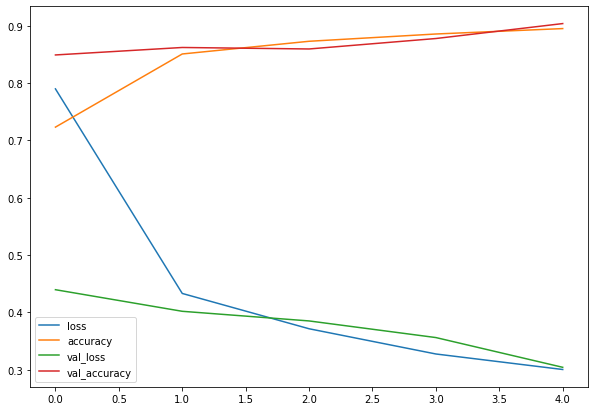

In [23]:
#Lets plot the training curve
import pandas as pd
pd.DataFrame(hist2.history).plot(figsize=(10,7));

In [24]:
#plot validation and training curve seperately
def plot_loss_curve(history):
  """
  Returns seperate loss curves for the metrics
  """
  train_loss = hist3.history['loss']
  val_loss = hist3.history['val_loss']

  accuracy = hist3.history['accuracy']
  val_accuracy = hist3.history['val_accuracy']

  epochs = range(len(hist3.history['loss']))

  #plot losses
  plt.plot(epochs, train_loss, label= 'Training loss')
  plt.plot(epochs, val_loss, label='Validation loss')
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  # plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label= 'Training accuracy')
  plt.plot(epochs, val_accuracy, label='Validation accuracy')
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')


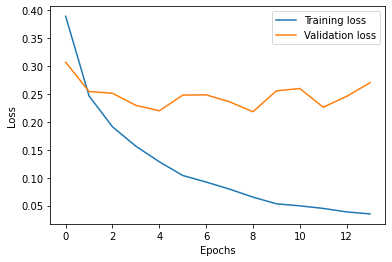

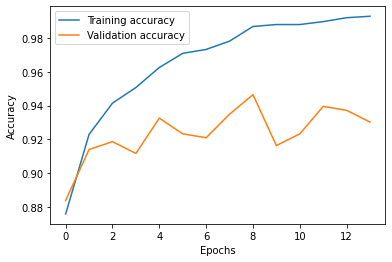

In [25]:
plot_loss_curve(hist3)

In [26]:
test_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
test_data = train_data_gen.flow_from_directory(test_dir, (image_size,image_size), batch_size=1, class_mode='categorical', shuffle=True)
print(class_names)

Found 435 images belonging to 5 classes.
['daisy' 'dandelion' 'rose' 'sunflower' 'tulip']


In [27]:
model_res.evaluate(test_data)

435/435 [==============================] - 8s 19ms/step - loss: 0.1807 - accuracy: 0.9333


[0.18069875240325928, 0.9333333373069763]

In [28]:
predictions = model_res.predict(test_data)

In [29]:

classes = class_names[np.argmax(predictions, axis = 1)]
classes


array(['daisy', 'tulip', 'rose', 'sunflower', 'dandelion', 'dandelion',
       'dandelion', 'tulip', 'sunflower', 'rose', 'daisy', 'tulip',
       'sunflower', 'daisy', 'dandelion', 'sunflower', 'dandelion',
       'daisy', 'dandelion', 'rose', 'dandelion', 'daisy', 'dandelion',
       'rose', 'daisy', 'sunflower', 'tulip', 'daisy', 'rose',
       'dandelion', 'daisy', 'dandelion', 'sunflower', 'dandelion',
       'daisy', 'rose', 'rose', 'tulip', 'sunflower', 'sunflower',
       'sunflower', 'tulip', 'daisy', 'dandelion', 'daisy', 'rose',
       'dandelion', 'sunflower', 'daisy', 'daisy', 'tulip', 'daisy',
       'daisy', 'rose', 'daisy', 'tulip', 'sunflower', 'daisy',
       'sunflower', 'dandelion', 'tulip', 'dandelion', 'tulip', 'rose',
       'tulip', 'sunflower', 'tulip', 'daisy', 'dandelion', 'daisy',
       'tulip', 'sunflower', 'daisy', 'dandelion', 'sunflower', 'daisy',
       'tulip', 'sunflower', 'tulip', 'sunflower', 'rose', 'dandelion',
       'tulip', 'tulip', 'rose', 'd

In [30]:
# Test and plot any image from the test data set. This below code snippet help you access the test images file names to further use in load and prep image function
import pathlib
import numpy as np
data_dir_daisy = pathlib.Path('../kaggle/working/Split/test/daisy') # turn our training path into a Python path
image_name_daisy = np.array(sorted([item.name for item in data_dir_daisy.glob('*')])) # created a list of class_names from the subdirectories

data_dir_rose = pathlib.Path('../kaggle/working/Split/test/rose') # turn our training path into a Python path
image_name_rose = np.array(sorted([item.name for item in data_dir_rose.glob('*')])) # created a list of class_names from the subdirectories

data_dir_tulip = pathlib.Path('../kaggle/working/Split/test/tulip') # turn our training path into a Python path
image_name_tulip = np.array(sorted([item.name for item in data_dir_tulip.glob('*')])) # created a list of class_names from the subdirectories

data_dir_sunflower = pathlib.Path('../kaggle/working/Split/test/sunflower') # turn our training path into a Python path
image_name_sunflower = np.array(sorted([item.name for item in data_dir_sunflower.glob('*')])) # created a list of class_names from the subdirectories

data_dir_dandelion = pathlib.Path('../kaggle/working/Split/test/dandelion') # turn our training path into a Python path
image_name_dandelion = np.array(sorted([item.name for item in data_dir_dandelion.glob('*')])) # created a list of class_names from the subdirectories

print(image_name_daisy)
print(image_name_rose)
print(image_name_tulip)
print(image_name_sunflower)
print(image_name_dandelion)

['10466290366_cc72e33532.jpg' '10559679065_50d2b16f6d.jpg'
 '105806915_a9c13e2106_n.jpg' '1286274236_1d7ac84efb_n.jpg'
 '1299501272_59d9da5510_n.jpg' '13583238844_573df2de8e_m.jpg'
 '14087947408_9779257411_n.jpg' '14114116486_0bb6649bc1_m.jpg'
 '14219214466_3ca6104eae_m.jpg' '147068564_32bb4350cc.jpg'
 '14866200659_6462c723cb_m.jpg' '15760153042_a2a90e9da5_m.jpg'
 '18684594849_7dd3634f5e_n.jpg' '19178753159_a471bf4b6b.jpg'
 '21626652132_97e1318bb8_m.jpg' '22244161124_53e457bb66_n.jpg'
 '2346726545_2ebce2b2a6.jpg' '2561371688_c80a4fe957_n.jpg'
 '2642408410_61545fdc83_n.jpg' '299129811_d6ebda9970.jpg'
 '3379332157_04724f6480.jpg' '33871813063_d7b6bedafe_n.jpg'
 '33879354664_615c72773d_n.jpg' '33885735373_444ba02d9c_n.jpg'
 '34287492780_6dab677857_n.jpg' '34288158610_6e42406193_n.jpg'
 '34508227161_a9ff840f71_n.jpg' '34518374242_310e7abd54_n.jpg'
 '34531542152_c8ba2e0fea_n.jpg' '34542837641_10492bf600_n.jpg'
 '34543119581_1fb7e0bd7f_n.jpg' '34637970155_a2b917077c_n.jpg'
 '34670512115_af22

In [31]:
def load_and_prep_image(test_sub_dir, filename, img_shape=224):
    
    target_dir = test_dir +'/'+ test_sub_dir
    
    target_file = target_dir + '/'+ filename
    
    img = tf.io.read_file(target_file)
    
    img = tf.image.decode_image(img, channels=3)
    
    img = tf.image.resize(img, size = [img_shape, img_shape])
    
    image = img
    
    img = tf.expand_dims(img, axis=0)
    
    pred = model_res.predict(img)
    
    class_name = class_names[np.argmax(pred, axis = 1)]
    
        
    return image, class_name[0]

This belongs to class tulip


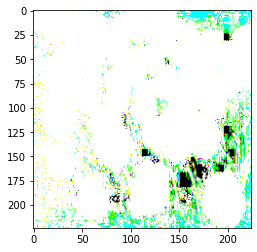

In [32]:
image, img = load_and_prep_image(test_sub_dir= 'tulip', filename = '14084211971_0f921f11fe_n.jpg', img_shape=224)

print('This belongs to class', img)
plt.imshow(image) ### Have to decompress the image


## Code to deprocess the image


# def deprocess_image(x):
#     # Util function to convert a tensor into a valid image
#     x = x.reshape((img_nrows, img_ncols, 3))
#     # Remove zero-center by mean pixel
#     x[:, :, 0] += 103.939
#     x[:, :, 1] += 116.779
#     x[:, :, 2] += 123.68
#     # 'BGR'->'RGB'
#     x = x[:, :, ::-1]
#     x = np.clip(x, 0, 255).astype("uint8")
#     return x